<a href="https://colab.research.google.com/github/cmanning00/Age-and-Gender-Prediction/blob/main/AgeGenderClass_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/drive/MyDrive/AgeGenderClassification/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

### Loading the Data

In [3]:
fold0 = pd.read_csv("/content/drive/MyDrive/AgeGenderClassification/Data/fold_0_data.txt",sep = "\t" )
fold1 = pd.read_csv("/content/drive/MyDrive/AgeGenderClassification/Data/fold_1_data.txt",sep = "\t")
fold2 = pd.read_csv("/content/drive/MyDrive/AgeGenderClassification/Data/fold_2_data.txt",sep = "\t")
fold3 = pd.read_csv("/content/drive/MyDrive/AgeGenderClassification/Data/fold_3_data.txt",sep = "\t")
fold4 = pd.read_csv("/content/drive/MyDrive/AgeGenderClassification/Data/fold_4_data.txt",sep = "\t")

In [4]:
folds = [fold0, fold1, fold2, fold3, fold4]
all_folds = pd.concat(folds, ignore_index=True)

In [5]:
all_folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [6]:
all_folds.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [7]:
all_folds.age.value_counts(dropna=False)

(25, 32)     5004
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2124
(15, 20)     1642
(60, 100)     872
(48, 53)      830
None          748
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
57             24
3              18
29             11
(38, 48)        6
58              5
32              3
2               3
56              2
42              1
46              1
(8, 23)         1
Name: age, dtype: int64

> It appears the age for some of the photos has been miscategorized.  The age groups should be any one of the following (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60+).  We will fix this later on.



In [8]:
all_folds.gender.value_counts(dropna=False)

f      9372
m      8120
u      1099
NaN     779
Name: gender, dtype: int64

> It also seems like some of the photos have not been assigned a gender or the gender was not able to be identified (indicated by `u`). These data points will be removed later on, otherwise, they could affect our model's accuracy.

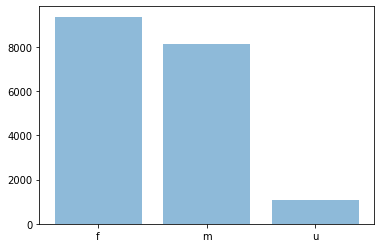

In [9]:
gender = ['f','m','u']
plt.bar(gender, all_folds.gender.value_counts(), align='center', alpha=0.5)
plt.show()

> The dataset seems to be mostly balanced between males and females.  Females have a slight majority

### Importing Libraries for Model Building

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

First, let's see what some of the photos look like:

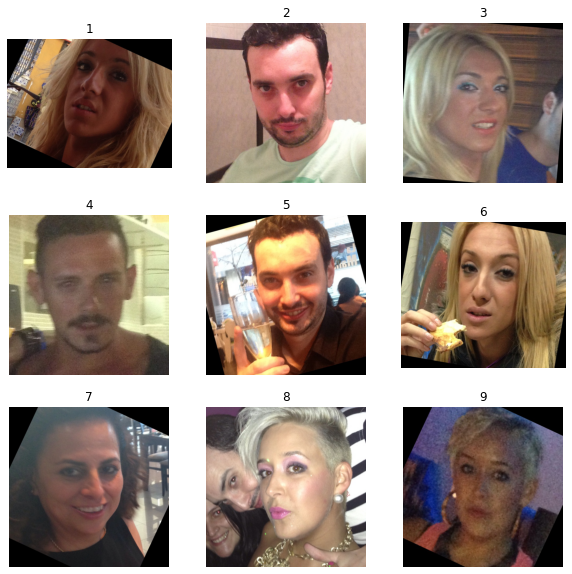

In [12]:
plt.figure(figsize=(10, 10))
#for images, labels in train_ds.take(1):
for i in range(9):
    path = "/content/drive/MyDrive/AgeGenderClassification/Data/faces/"+all_folds.user_id.loc[i]+"/coarse_tilt_aligned_face."+str(all_folds.face_id.loc[i])+"."+all_folds.original_image.loc[i]
    ax = plt.subplot(3, 3, i + 1)
    img = load_img(path)
    plt.imshow(img)
    #plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(int(labels[i]))
    plt.title(i + 1)
    plt.axis("off")

### Collect a subset of only the relevant data

In [13]:
list(all_folds.columns)

['user_id',
 'original_image',
 'face_id',
 'age',
 'gender',
 'x',
 'y',
 'dx',
 'dy',
 'tilt_ang',
 'fiducial_yaw_angle',
 'fiducial_score']

> Some of these columns will not help us for age or gender classification.  Let's keep only those that we need.

In [14]:
imp_data = all_folds[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
#imp_data.info()
list(imp_data.columns)

['age', 'gender', 'x', 'y', 'dx', 'dy']

Now we will create a column containing the file path for all the relevant images.  This will make it easy to find the correct images later on when training our models.  

In [15]:
img_path = []
faces_location = "/content/faces/" # Change this variable to the location of your faces data

for row in all_folds.iterrows():
    path = faces_location+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
    
imp_data['img_path'] = img_path

In [16]:
pd.set_option('display.max_colwidth', None)
imp_data.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,/content/faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg
1,"(25, 32)",m,301,105,640,641,/content/faces/30601258@N03/coarse_tilt_aligned_face.2.10424815813_e94629b1ec_o.jpg
2,"(25, 32)",f,2395,876,771,771,/content/faces/30601258@N03/coarse_tilt_aligned_face.1.10437979845_5985be4b26_o.jpg
3,"(25, 32)",m,752,1255,484,485,/content/faces/30601258@N03/coarse_tilt_aligned_face.3.10437979845_5985be4b26_o.jpg
4,"(25, 32)",m,175,80,769,768,/content/faces/30601258@N03/coarse_tilt_aligned_face.2.11816644924_075c3d8d59_o.jpg


> Great!  Now it will be easy to gather all the necessary photos during training. 

We will now create a dictionary to map the miscategoriezed ages to the correct category.  We will also remove any entries that have missing ages.

In [17]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), 
               ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), 
               ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), 
               ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), 
               ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), 
               ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), 
               ('58', '60+')]
age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []

In [18]:
for idx, each in enumerate(imp_data.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        imp_data.age.iloc[idx] = age_mapping_dict[each]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
imp_data = imp_data.drop(labels=drop_labels, axis=0) #dropped None values

In [20]:
imp_data.age.value_counts(dropna=False)

25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

We will now drop any rows with `na` values and where the gender is unknown

In [21]:
imp_data = imp_data.dropna()
clean_data = imp_data[imp_data.gender != 'u'].copy()
clean_data.gender.value_counts()

f    9332
m    8120
Name: gender, dtype: int64

Let's see how balanced the data is among different age groups and genders

In [22]:
groupby2 = clean_data.groupby(['age', 'gender']).x.count().reset_index().rename(columns={'x':'count'})

In [23]:
groupby2_ordered = groupby2.iloc[[0,1,8,9,14,15,2,3,4,5,6,7,10,11,12,13]]

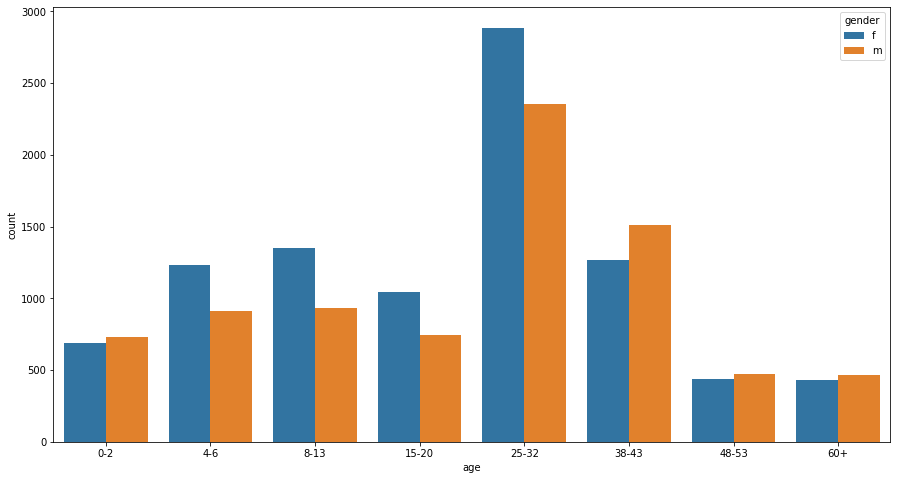

In [24]:
plt.figure(figsize=(15,8))
sns.barplot(data=groupby2_ordered, x='age', y='count', hue='gender')

> As we saw before, the data is pretty balanced among genders with females having a majority.  The data is not, however, very balanced among age groups.  This is likely due to the fact that all of these photos were uploaded from smart phones.  Children and infants as well as the elderly, are much less likely to have smart phones.  So, it makes sense there are fewer individuals of those ages in this dataset. 

> But, it is important to take note of this because our model should perform better for the age groups that appear the most and worse for those that appear the least.  

Now, we will map gender to 0 for 'f' and 1 for 'm' so it is in a machine readable format for our neural network.  

In [25]:
gender_to_binary_map = {
    'f' : 0,
    'm' : 1
}
clean_data['gender'] = clean_data.gender.apply(lambda g: gender_to_binary_map[g])
clean_data.head()

,age,gender,x,y,dx,dy,img_path
0,25-32,0,0,414,1086,1383,/content/faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg
1,25-32,1,301,105,640,641,/content/faces/30601258@N03/coarse_tilt_aligned_face.2.10424815813_e94629b1ec_o.jpg
2,25-32,0,2395,876,771,771,/content/faces/30601258@N03/coarse_tilt_aligned_face.1.10437979845_5985be4b26_o.jpg
3,25-32,1,752,1255,484,485,/content/faces/30601258@N03/coarse_tilt_aligned_face.3.10437979845_5985be4b26_o.jpg
4,25-32,1,175,80,769,768,/content/faces/30601258@N03/coarse_tilt_aligned_face.2.11816644924_075c3d8d59_o.jpg


Now we will change the age column to have numeric labels for the same reason why we changed the gender column.

In [26]:
age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}
clean_data['age'] = clean_data['age'].apply(lambda age: age_to_label_map[age])
clean_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,/content/faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg
1,4,1,301,105,640,641,/content/faces/30601258@N03/coarse_tilt_aligned_face.2.10424815813_e94629b1ec_o.jpg
2,4,0,2395,876,771,771,/content/faces/30601258@N03/coarse_tilt_aligned_face.1.10437979845_5985be4b26_o.jpg
3,4,1,752,1255,484,485,/content/faces/30601258@N03/coarse_tilt_aligned_face.3.10437979845_5985be4b26_o.jpg
4,4,1,175,80,769,768,/content/faces/30601258@N03/coarse_tilt_aligned_face.2.11816644924_075c3d8d59_o.jpg


### Train / Test Split

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X = clean_data[['img_path']]
y = clean_data[['gender']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Train data shape {X_train.shape}')
print(f'Test data shape {X_test.shape}')

Train data shape (12216, 1)
Test data shape (5236, 1)


In this next step we are going to resize the photos to all be 227 x 227.  If you are using Google Colab, this process is normally extremely slow.  That's because each image needs to be read from Google Drive before it can be processed and reading from Google Drive slows things down significantly.  One solution is to upload the image data right into Google Colab, so we don't have to pull from the drive each time.  In order to do so, you must make sure to have a copy of the unzipped faces data in your mounted Google Drive.  The code below will then unzipped this data and prevent any slowdowns.  

In [29]:
!tar -xvf "/content/drive/MyDrive/AgeGenderClassification/faces.tar.gz" -C "/content"

Streaming output truncated to the last 5000 lines.
faces/114841417@N06/coarse_tilt_aligned_face.490.12080156125_b2f8be57d2_o.jpg
faces/7464014@N04/coarse_tilt_aligned_face.962.10091646405_f39ebedb52_o.jpg
faces/68825596@N05/coarse_tilt_aligned_face.295.11593832374_2b7a578239_o.jpg
faces/20696814@N02/coarse_tilt_aligned_face.2256.11495765605_4d04d57b02_o.jpg
faces/113525713@N07/landmarks.1011.11784137524_654505d9e6_o.txt
faces/8034587@N06/landmarks.700.11299390836_0e5e2ba387_o.txt
faces/8410632@N03/coarse_tilt_aligned_face.1781.11257308124_d177707924_o.jpg
faces/10792106@N03/landmarks.539.11042876695_165998f9bd_o.txt
faces/19393853@N00/landmarks.1317.10734390864_910049bac7_o.txt
faces/30601258@N03/coarse_tilt_aligned_face.2.11234009374_1e0ced7c90_o.jpg
faces/45666944@N00/landmarks.407.11843176994_e17a431ea3_o.txt
faces/50739822@N00/coarse_tilt_aligned_face.1366.8527206319_115d3d865a_o.jpg
faces/48135726@N02/landmarks.2106.11309148494_362e8423da_o.txt
faces/62501130@N02/coarse_tilt_align

Now we will gather all of the images in the train set using the file path column we previously made.  This would have taken hours without having downloaded the zip file directly into Google Colab.

In [30]:
train_images = []
idx = 0
tot_rows = len(X_train) - 1
for row in X_train.iterrows():

    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    #image = image.resize((224, 224))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

    if idx % 1000 == 0:
        print(f'\n{idx}/{tot_rows}')
    elif idx % 200 == 0:
        print(idx)
    elif idx == tot_rows:
      print(f'\n{idx}/{tot_rows}')
      print('---------------------Done---------------------')
    idx += 1


0/12215
200
400
600
800

1000/12215
1200
1400
1600
1800

2000/12215
2200
2400
2600
2800

3000/12215
3200
3400
3600
3800

4000/12215
4200
4400
4600
4800

5000/12215
5200
5400
5600
5800

6000/12215
6200
6400
6600
6800

7000/12215
7200
7400
7600
7800

8000/12215
8200
8400
8600
8800

9000/12215
9200
9400
9600
9800

10000/12215
10200
10400
10600
10800

11000/12215
11200
11400
11600
11800

12000/12215
12200

12215/12215
---------------------Done---------------------


In [31]:
train_images = np.asarray(train_images)
print('Train images shape {}'.format(train_images.shape))

Train images shape (12216, 227, 227, 3)


We do the same for the test set.

In [32]:
test_images = []
idx = 0
tot_rows = len(X_test) - 1
for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    #image = image.resize((224, 224))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)
    
    if idx % 1000 == 0:
        print(f'\n{idx}/{tot_rows}')
    elif idx % 200 == 0:
        print(idx)
    elif idx == tot_rows:
      print(f'\n{idx}/{tot_rows}')
      print('---------------------Done---------------------')
    idx += 1


0/5235
200
400
600
800

1000/5235
1200
1400
1600
1800

2000/5235
2200
2400
2600
2800

3000/5235
3200
3400
3600
3800

4000/5235
4200
4400
4600
4800

5000/5235
5200

5235/5235
---------------------Done---------------------


In [33]:
test_images = np.asarray(test_images)
print('Test images shape {}'.format(test_images.shape))

Test images shape (5236, 227, 227, 3)


## Build the Models

Now let's build our classifiers, starting with the gender classifier.

### Gender Model

I built this convolutional neural network by modifying Google's famous VGG16 model.  I made some changes and found what increased accuracy through trial and error.  

In [34]:
input_shape = (227, 227, 3)
model = Sequential(
    [
        keras.Input(shape=input_shape),
  
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
     
        Conv2D(128, kernel_size=(3, 3), activation="relu"),
        Conv2D(128, kernel_size=(3, 3), activation="relu"), ##
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(256, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
     
        Conv2D(512, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
     
        Conv2D(512, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        

        Dropout(0.5),
     
        Flatten(),
        Dense(units=2, activation="softmax")

    ]
)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0

### Train the model

In [36]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print(type(y_train))
print(type(y_test))
print(y_train.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(12216, 1)
(5236, 1)


Connecting to GPU

We will now connect to a GPU on Google Colab.  This speeds up the model training process dramatically.  I high recommend training the model using Google Colab if you do not already have a CUDA-enabled GPU on your computer.  Without a GPU each epoch takes several minutes to run and just seconds with a GPU.  Fortunately, Google Colab provides free GPU usage.

In [37]:
%tensorflow_version 2.x
#import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [38]:
num_epochs = 35 #25
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5) # Callback for earlystopping
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=32, epochs=num_epochs, validation_data=(test_images, y_test), callbacks=[callback])

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

#model.save('gender_model25.h5')

Epoch 1/35
382/382 [==============================] - 99s 221ms/step - loss: 2.8906 - accuracy: 0.6022 - val_loss: 0.8138 - val_accuracy: 0.5783
Epoch 2/35
382/382 [==============================] - 77s 200ms/step - loss: 0.5927 - accuracy: 0.7009 - val_loss: 0.5287 - val_accuracy: 0.7674
Epoch 3/35
382/382 [==============================] - 77s 200ms/step - loss: 0.5197 - accuracy: 0.7565 - val_loss: 0.4463 - val_accuracy: 0.7882
Epoch 4/35
382/382 [==============================] - 77s 201ms/step - loss: 0.4604 - accuracy: 0.7785 - val_loss: 0.5301 - val_accuracy: 0.7359
Epoch 5/35
382/382 [==============================] - 79s 207ms/step - loss: 0.4305 - accuracy: 0.7960 - val_loss: 0.3660 - val_accuracy: 0.8337
Epoch 6/35
382/382 [==============================] - 77s 200ms/step - loss: 0.3831 - accuracy: 0.8231 - val_loss: 0.3664 - val_accuracy: 0.8333
Epoch 7/35
382/382 [==============================] - 76s 200ms/step - loss: 0.3561 - accuracy: 0.8381 - val_loss: 0.3458 - val_ac

> It looks like we were able to get our gender classifier to have an accuracy of about 91%.  That's pretty good!.  We could probably further increase the accuracy with more epochs.  

In the next part of this notebook, we will be working on the age classifier.  